## Process Optimization - the `Main` code 

### Fourth Batch of Bayesian Optimization based on Experimental Data produced on Nov 8, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [1]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_all_device  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
#print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:-3]
df_all_device = df_all_device.dropna()
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_all_device

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590
...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [4]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               'alpha':0.99
               }

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 1.0751
test rmse: 0.8598
all rmse: 1.0351
train R^2: 0.9415
test R^2: 0.9521
all R^2: 0.9433
train spearman: 0.9296
test spearman: 0.9419
all spearman: 0.9310


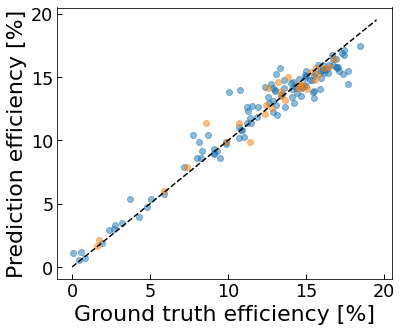

In [6]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [7]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [8]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [9]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


parameter_space = ParameterSpace([ContinuousParameter('temp', 0,1),
                                 ContinuousParameter('speed', 0,1),
                                 ContinuousParameter('sprayFL', 0,1),
                                 ContinuousParameter('plamsaH', 0,1),
                                 ContinuousParameter('gasFL', 0,1),
                                 ContinuousParameter('plasmaDC', 0,1)
                                 ])

In [10]:
df_thiswork  = pd.read_excel("./ML Perov Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'

In [11]:
df_thiswork[thiswork_device].iloc[:,2:-1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.2619,0.932514,0.39,5.914137
2,135,200,2500,1.0,25,75,23.1761,0.926920,0.60,12.889485
6,140,150,4000,1.0,20,75,19.9090,1.023000,0.69,14.053536
8,130,175,3500,0.8,25,75,21.8800,1.044000,0.74,16.904349
9,135,125,2500,1.2,20,25,22.0476,1.025000,0.71,16.045155
...,...,...,...,...,...,...,...,...,...,...
94,140,150,3500,1.2,20,50,19.7860,1.021000,0.79,15.959000
95,140,150,3500,1.0,20,50,18.9330,0.978000,0.58,10.739000
96,145,125,3000,1.2,16,50,22.7520,0.987000,0.74,16.621000
97,150,175,3500,1.0,16,50,26.4330,0.978000,0.58,14.988000


### Load the previous experimental data

In [12]:
df_previous  = pd.read_excel("./ML Perov Data/new_plamsa_previous_selected_20200927.xlsx", sheet_name= "Sheet1")
df_previous.iloc[:,2] = df_previous.iloc[:,2] /10
df_previous.iloc[:,3] = df_previous.iloc[:,3] /1000

print(df_previous.columns)
df_previous.columns = ['', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [cm/s]',
       'Spray Flow [mL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_previous = df_previous.sort_values(by=list(df_previous.iloc[:,[1,2,3,4,5,6,-1]].columns), ignore_index = True)
# df_previous = df_previous.drop_duplicates(['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
#        'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]'], keep = 'last', ignore_index = True)
df_previous = df_previous.iloc[:,1:]
df_previous

Index(['Unnamed: 0', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', 'Jsc [mA/cm2]',
       'Voc [V]', 'FF [-]', 'Efficiency [%]'],
      dtype='object')


,Temperature [°C],Speed [cm/s],Spray Flow [mL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,125,10.0,2.5,1.5,15,100,0.763209,16.678352,0.561663,7.1494
1,125,10.0,2.5,1.5,15,100,0.764307,16.693951,0.594879,7.5902
2,125,15.0,3.0,1.0,15,100,0.777895,22.145733,0.589384,10.1534
3,125,15.0,3.0,1.0,15,100,0.933930,21.041220,0.661820,13.0054
4,135,10.0,2.5,1.0,15,100,0.780622,18.418326,0.593654,8.5354
...,...,...,...,...,...,...,...,...,...,...
61,145,20.0,5.0,1.0,15,100,0.966357,19.217004,0.682210,12.6690
62,145,20.0,5.0,1.0,15,100,0.957637,19.597432,0.728667,13.6751
63,150,10.0,3.5,1.0,15,100,0.966984,19.472074,0.628517,11.8345
64,150,10.0,3.5,1.0,15,100,0.937632,20.745524,0.676690,13.1627


### Define the Probabilistic Constrained Bayesian Optimization Loop
- This Optimization loop takes in two contraint functions (one for binary film quality; one for previous device data)
- The data for constraint function is converted into a probablistic constraint (with a scaling factor spec the contraint strength on the acquisition function)

In [13]:
from typing import Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

class ProbabilisticConstraintBayesianOptimizationLoop2(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint1: Union[IModel, IDifferentiable], 
                 model_constraint2: Union[IModel, IDifferentiable],
                 acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')
        self.model_objective = model_objective
        self.model_constraint1 = model_constraint1
        self.model_constraint2 = model_constraint2
        
        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
        
        acquisition_constraint1 = ScaledProbabilityOfFeasibility(model_constraint1, max_value = 1, min_value = 0.5)
        acquisition_constraint2 = ScaledProbabilityOfFeasibility(model_constraint2, max_value = 1, min_value = 0.8)
        acquisition_constraint = acquisition_constraint1*acquisition_constraint2
        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint1 = FixedIntervalUpdater(model_constraint1, update_interval,
                                                        lambda state: state.Y_constraint1)
        model_updater_constraint2 = FixedIntervalUpdater(model_constraint2, update_interval,
                                                        lambda state: state.Y_constraint2)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)
        
        #loop_state = create_loop_state(model_objective.X, model_objective.Y, Y_constraint=model_constraint.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop2, self).__init__(candidate_point_calculator,
                                                                              [model_updater_objective, model_updater_constraint1,model_updater_constraint2],
                                                                              loop_state)
#     def suggest_next_locations(self):
#         return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [14]:
from typing import Tuple, Union
import scipy.stats
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable

class ScaledProbabilityOfFeasibility(Acquisition):

    def __init__(self, model: Union[IModel, IDifferentiable], jitter: float = float(0),
                 max_value: float = float(1), min_value: float = float(0)) -> None:
        """
        This acquisition computes for a given input point the probability of satisfying the constraint
        C<0. For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param jitter: Jitter to balance exploration / exploitation
        """
        self.model = model
        self.jitter = jitter
        self.max_value = max_value
        self.min_value = min_value

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: numpy array with the probability of satisfying the constraint at the points x.
        """
        mean, variance = self.model.predict(x)
        mean += self.jitter

        standard_deviation = np.sqrt(variance)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        return cdf*(self.max_value-self.min_value)+self.min_value

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the  probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: tuple of numpy arrays with the probability of satisfying the constraint at the points x 
        and its gradient.
        """
        mean, variance = self.model.predict(x)
        standard_deviation = np.sqrt(variance)

        dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
        dstandard_devidation_dx = dvariance_dx / (2 * standard_deviation)

        mean += self.jitter
        u = - mean / standard_deviation
        pdf = scipy.stats.norm.pdf(0, mean, standard_deviation)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        dcdf_dx = - pdf * (dmean_dx + dstandard_devidation_dx * u)

        return cdf*(self.max_value-self.min_value)+self.min_value, dcdf_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

### Run GP Regression on the Experimental Data
- Experimental device data for round 0 initial sampling and round 1 experiments: device efficiency
- Experimental film data for round 0 initial sampling and round 1 experiments: binary film quality
- Previous experiment data of the "new plasma" nozzle: device efficiency

### Start the First Run of the Batch-mode Bayesian Optimization 

In [15]:
#np.random.seed(10)
import emukit
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

#from sklearn.preprocessing import StandardScaler

BO_list_LHS20 = []
for n in np.arange(100):
    design = LatinDesign(parameter_space)
    x_LHS = design.get_samples(20)
    x_init = x_denormalizer(x_LHS)
    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(x_init))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)


    y_pred_init = scaler_y.inverse_transform(y_hat_mean)
    max(y_pred_init)

    X = x_normalizer(x_init)
    Y = np.transpose([y_pred_init])

    # std_scaler = StandardScaler()
    # std_scaler.fit(X)
    # X= std_scaler.transform(X)

    input_dim = len(X[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
    ker.lengthscale.constrain_bounded(1e-1, 1)
    ker.variance.constrain_bounded(1e-1, 1000.0)
    # ker += GPy.kern.White(input_dim = input_dim)
    # ker += GPy.kern.Bias(input_dim = input_dim)
    model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
#     model_gpy.Gaussian_noise.variance = 1.5**2
#     model_gpy.Gaussian_noise.variance.fix()
    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
    objective_model = GPyModelWrapper(model_gpy)

    from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
    from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement


    ## Expeceted Improvement (EI)
    ## acquisition = ExpectedImprovement(objective_model, jitter=.1)
    ## Lower Confidence Bound (LCB)
    acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
    ## Maximum Value Entropy Search (MES)
    # acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*6)

    ## fully integreated acquisition
    # #acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
    # acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
    # acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
    # acquisition = acquisition_integrated

    # Make loop and collect points
    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                     space=parameter_space, 
                                     acquisition=acquisition,
                                     batch_size = 20)#batchsize>20 to account for duplication

    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

    print('total condition no.:', len(X))
    print('total device no.:', len(bayesopt.loop_state.Y))
    print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

    X_all = x_denormalizer(np.append(X,X_new,axis = 0))

    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(X_all))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_all_pred = scaler_y.inverse_transform(y_hat_mean)


    df_Xall = pd.DataFrame(X_all, columns = df_thiswork.columns[2:8])
    df_Xall['Efficiency [%]'] = y_all_pred


    for i in np.arange(14):

        X = x_normalizer(df_Xall.iloc[:,:6].values)
        Y = np.transpose([df_Xall.iloc[:,-1].values])

        # std_scaler = StandardScaler()
        # std_scaler.fit(X)
        # X= std_scaler.transform(X)

        input_dim = len(X[0])
        ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
        ker.lengthscale.constrain_bounded(1e-1, 1)
        ker.variance.constrain_bounded(1e-1, 1000.0)
        # ker += GPy.kern.White(input_dim = input_dim)
        # ker += GPy.kern.Bias(input_dim = input_dim)
        model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
    #     model_gpy.Gaussian_noise.variance = 1.5**2
    #     model_gpy.Gaussian_noise.variance.fix()
        model_gpy.randomize()
        model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
        objective_model = GPyModelWrapper(model_gpy)

        from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
        from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement


        ## Expeceted Improvement (EI)
        ## acquisition = ExpectedImprovement(objective_model, jitter=.1)
        ## Lower Confidence Bound (LCB)
        acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
        ## Maximum Value Entropy Search (MES)
        # acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*6)

        ## fully integreated acquisition
        # #acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
        # acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
        # acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
        # acquisition = acquisition_integrated

        # Make loop and collect points
        bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                         space=parameter_space, 
                                         acquisition=acquisition,
                                         batch_size = 20)#batchsize>20 to account for duplication

        print('total condition no.:', len(X))
        print('total device no.:', len(bayesopt.loop_state.Y))
        print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

        
        X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

        f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

   
        X_all = x_denormalizer(np.append(X,X_new,axis = 0))

        y_hat_list = []
        for i in np.arange(len(GBregressor_list)):
            y_hat = GBregressor_list[i].predict(scaler.transform(X_all))
            y_hat_list.append(y_hat)
        y_hat_mean = np.mean(y_hat_list, axis = 0)
        y_all_pred = scaler_y.inverse_transform(y_hat_mean)


        df_Xall = pd.DataFrame(X_all, columns = df_thiswork.columns[2:8])
        df_Xall['Efficiency [%]'] = y_all_pred


    print(df_Xall.iloc[np.argmax( df_Xall['Efficiency [%]'].values):np.argmax( df_Xall['Efficiency [%]'].values)+1])

    BO_list_LHS20.append(df_Xall['Efficiency [%]'].values)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.71
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
313        144.149354     178.18537          3462.028139            1.066568   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
313                     15.0      27.092082       17.659978  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.47
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
311        145.843301    137.294077          3725.655457                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
311                     15.0      31.792471       16.750456  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.38
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  13.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  14.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  14.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  14.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  14.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  14.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  14.75


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
177        141.633496    246.049656           3768.51699            1.067235   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
177                     15.0      49.746283       14.761669  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.64
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.86


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.91


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.15


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
305        143.871478    136.533756          3476.752666                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
305                     15.0           25.0       16.798689  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.21
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.22


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.32


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.49


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
312        136.608143    186.058868          3494.792406            1.195632   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
312                15.707192       28.56516       16.922707  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.68
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
128        144.537047    186.353435          3418.295914            1.081902   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
128                     15.0      56.954414       16.680231  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.5
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.93


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
289        139.994831    174.776532          3944.158117            1.108256   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
289                     15.0           25.0       16.699177  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.31
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.27


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.64


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
279        143.273553    179.880827          3772.492686            1.055779   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
279                     15.0      55.172219       16.652023  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.62
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
266        144.380373    144.567163          3346.290181                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
266                     15.0      28.635793       17.503103  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.57
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.46


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.46


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.22


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.16


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.16


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
257        142.425523    184.715787          3801.346938            1.051712   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
257                15.236081      30.050839       17.367834  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.7
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
282        140.636702    186.851617          3363.544923            1.091529   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
282                     15.0      31.988531        17.02955  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  12.77
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.01


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
246        145.574948    176.898343          3907.060046                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
246                     15.0      26.614781       17.293446  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.44
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
278        143.840443      133.9672          3970.924339                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
278                     15.0       28.31057       16.736219  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.73
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.46


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.77


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
301        145.114889    183.657839          3432.503786                 0.8   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
301                     15.0           25.0       16.741439  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.23
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  17.05


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.53


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.53


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.53


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.53


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.62


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.64


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.64


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
262        144.305516     177.27653          3446.850001            1.088037   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
262                     15.0       30.76087       17.639805  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.02


reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.8


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
164        143.978335    181.896975          3447.932402            1.071742   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
164                15.758477      49.928034       16.732117  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.32
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  15.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
188        138.249868    179.656261           3471.68866                 0.8   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
188                18.596157      66.570232       16.167105  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.34
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.25


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
297        145.396122    177.941982           3399.18916                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
297                     15.0      26.112131       17.539287  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.51
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.64


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.83


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.66


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.07


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.57


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.63


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.63


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.63


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
316         145.88746    185.865696          3434.056422            1.072278   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
316                     15.0       29.50324       17.662137  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  12.71
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  15.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
181        138.676435    183.156174          3989.185847            1.097768   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
181                16.184123      57.770968        16.30067  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.67
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.65


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
315          144.3817    142.755798          3427.970649                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
315                     15.0      26.970112       17.432169  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.92
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.77


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.77


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.86


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.86


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.86


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
301        146.470932    175.991436           3995.93601            1.181807   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
301                15.155232      29.504958       17.283525  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  12.79
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.8


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
276        143.369976    175.000801           3356.50431            1.082776   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
276                 16.16252      29.592622       17.638241  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.84
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.79


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
310        145.248815    142.515672          3341.475148                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
310                     15.0      29.953139       17.477868  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.11
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.25


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.55


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
287        137.567176    134.955198          3014.693207            1.197351   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
287                     15.0       26.00984       16.545269  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.5
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.67


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
238         134.28839    129.771738          3225.718813            1.068981   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
238                     15.0      28.752226       16.694359  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.05
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
148        145.815354    179.390361          3971.020255            1.065395   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
148                     15.0      59.127653       16.655978  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.65
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
151        145.522186    177.494045          3471.649211            1.074854   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
151                     15.0       56.16679       16.744381  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.22
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.67


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.01


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.01


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
284        143.041084    129.326977          3152.842322                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
284                15.515084      26.616709       17.419608  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.75
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
196        142.556346    143.768535          3325.559972                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
196                     15.0       28.37276       17.512579  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.62
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
175        143.422895     186.29033          3424.727122                 0.8   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
175                20.814359      62.973903       16.128742  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.28
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.06


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
148        143.129016    178.712956          3786.228784                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
148                     15.0      52.773786       16.648103  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.43
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.41


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.78


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.93


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.29


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.35


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.35


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
220        143.300984    181.011106          3855.432218             1.09566   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
220                     15.0      30.354282       17.346142  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.66
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
249        142.692454    178.687526          3313.162115                 0.8   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
249                19.184958           25.0        16.69508  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.18
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.49


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.45


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
183         143.45897    183.705091          3880.185725            1.109069   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
183                     15.0      37.584758       16.704181  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.22
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


    Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
62        144.773374    180.352369          3451.859125             1.19262   

    Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
62                     15.0      49.615767       16.706072  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.54
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
312        146.291563    181.729505          3336.353922                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
312                16.289577      54.991728       16.653446  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.84


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.75


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.75


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
279        140.499487    182.051182          3668.939204                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
279                     15.0      29.463931       16.749162  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.4
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.99


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.61


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.13
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
290        147.067285    176.596191          3536.165709            1.071674   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
290                     15.0      31.042881       17.128242  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.69
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
271        144.153275    129.764835          2968.112673            1.179531   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
271                     15.0      52.940039       16.690397  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  14.93


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.91


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.55


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
278         142.73205    129.180716          3167.771437            1.083284   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
278                16.462337       29.55258       17.342873  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  12.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.93


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
194        145.561248    175.702372          3853.512138               1.063   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
194                     15.0      50.563188       16.655978  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.86


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.32


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.9


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.08
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
313        142.529699    145.966571           3320.91834                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
313                     15.0           25.0       17.150733  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.74
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
197        145.820417    180.818834          3448.205953            1.069395   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
197                     15.0      53.602924       16.739126  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.01


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.15


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
132         143.12213    179.921927          3963.875693            1.058321   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
132                     15.0      52.801405       16.652023  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.78


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
303         143.25188    180.861871          3412.063525            0.804688   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
303                15.050095      31.057169        16.93381  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
297        143.392693     160.77798          3417.928998                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
297                     15.0      26.520984       17.170631  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.41


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.41


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.79


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.79
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
319        144.314468    148.946238          3320.436415            1.113868   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
319                     15.0      27.266368       17.277965  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
210        145.812732    177.132954          3473.306709            1.090043   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
210                     15.0      29.295836       17.649693  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.55


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
291         143.23904    127.636762          3153.599891                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
291                  15.9597      27.230516       17.435209  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.58
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
293        143.154933    179.410605          3448.989489            1.188977   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
293                     15.0      28.240572       17.579818  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.61


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.31


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.34
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
172        143.135225    179.954092          3769.198244            1.071726   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
172                19.205596      59.242894       16.338372  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.25


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
266        143.439047    177.640264          3430.497623                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
266                     15.0           25.0       17.295709  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
216        145.993884    178.497154           3421.53442            0.806222   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
216                15.339511      28.063265       16.972686  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.06
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
284        143.186523    147.864862          3374.138539                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
284                     15.0           25.0       17.055058  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
237        143.263872     181.33142          3452.175455                 0.8   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
237                18.586811      27.342027       17.068267  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.67


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
301        144.985867    185.357161          3431.530789            1.058996   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
301                15.551333      28.395148       17.668987  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.9


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.98


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
306        143.183518    183.668578          3861.867553            1.074033   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
306                     15.0      53.035774       16.652023  


reconstraining parameters Mat52.variance
 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.19
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.94


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.88


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.88


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.88


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.04


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.04


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.11


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.11


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.11


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.34


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.4


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.4


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
262         144.27567    130.258664          3146.643907            1.179414   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
262                15.639253      27.547414       17.395837  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.17
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.63
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
179        143.764409    179.857519          3851.713497            1.096291   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
179                     15.0      49.473761       16.625885  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.8


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.33


reconstraining parameters Mat52.lengthscale


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
284         143.26736    179.588757           3626.12835            1.069509   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
284                     15.0      27.589887       17.331958  


reconstraining parameters Mat52.variance
 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.96


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.96


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.83


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.0


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.25


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.29


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.31


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.36


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
293         142.48554    180.052572          3782.707574             1.08316   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
293                     15.0      28.581746       17.361546  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.52
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.88


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.46


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
295        144.444804    146.475939          3388.073836                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
295                     15.0      30.966624       17.461079  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.07


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
229        145.709981    177.950405          3917.419908             1.06964   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
229                     15.0       50.19636       16.655978  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.14
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  14.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.49


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
169        144.739674    181.615593          3459.106599            1.084201   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
169                15.292067      72.450631       16.732035  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.97


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.19


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.55


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
245        145.681053    178.429228          3450.419616                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
245                15.402964      27.632992       17.573174  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.93


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.45


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
206         144.70608    125.273098          2921.958413            1.105056   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
206                15.227556      54.776574       16.534049  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.82


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.5


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.6


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
317        148.238294    178.791883          3450.648429            1.073192   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
317                     15.0           25.0       16.883508  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.21
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.45


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.41


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
318        143.041748    177.566709           3482.41703            1.067439   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
318                18.805361      28.577161       17.433521  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.62
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.45


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
220        144.551618    144.052321          3354.204813                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
220                     15.0      26.992435       17.515454  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.2


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.32


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.33


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.33


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.33


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
319        142.277692    180.240475          3849.515593             1.08194   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
319                     15.0       52.30161         16.6254  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.22
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
176        143.178074    176.177992          3542.799784            1.056089   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
176                     15.0           25.0       17.055202  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.31
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.44


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.47


reconstraining parameters Mat52.lengthscale


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
300        144.217375    144.438423           3347.66131                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
300                     15.0      28.536213        17.50425  


reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.76


reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.31


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.31


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.31


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.61


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.61


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.64


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
244        143.057767    179.935579          3872.143892                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
244                     15.0      58.622529       16.647083  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.14
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.26


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.72


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.53


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.55


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
293        144.870644    181.308929          3340.325695                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
293                     15.0      29.013343       17.545159  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.7
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.05


reconstraining parameters Mat52.lengthscale


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
247        142.417255    131.688906          2951.649472            1.101327   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
247                16.221296           25.0       17.053723  


reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.93
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.83


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.62


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.64
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
300        143.369688    182.650792          3780.498881            1.061567   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
300                     15.0      57.741206       16.652023  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.22
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.06


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.16


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.58


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
210        144.629076    177.761133          3806.176225            1.067632   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
210                     15.0      55.903473       16.645365  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.67


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.48


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
224        143.292154    145.168202          3345.904002            1.113117   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
224                     15.0      28.069821       17.391092  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.91


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.75


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.77


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.0


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
309        144.739961    129.497268          3154.532159            1.062285   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
309                     15.0      29.050426       17.357167  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.04
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.17


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.37
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
273        144.389684    144.617207          3334.000928            1.075361   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
273                15.618806      28.170135       17.371328  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.15
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.79


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  14.79


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.4


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.91


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.91


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
271        136.254389    139.588573          3492.035614                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
271                     15.0       27.09261       16.911335  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.1


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.68


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
217        143.746364    182.402117          3782.409192            1.177683   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
217                     15.0       28.15441       17.284814  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.24
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.38


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
298         145.98069    174.567994          3866.209346            1.094321   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
298                     15.0      27.927372       17.355664  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.14


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
246        145.002792     123.82823          2996.959027            1.175039   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
246                     15.0      58.149508       16.712734  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.68
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.89


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.01


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.29


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
279        142.000175    181.238535          3796.804458            1.192693   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
279                     15.0      27.224419       17.301879  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.2


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.71


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
222        145.977331    178.714247          3868.006601            1.070996   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
222                     15.0      49.297515       16.655978  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.45
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.73


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.96


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.12


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.57


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.7


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
303        146.443138    179.181184          3807.698065            1.050212   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
303                15.942015      28.117746       17.354822  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.62
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.56


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.24


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.59


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.95


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.09


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.25


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.3


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
307        142.708575    139.435737          3358.219858                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
307                     15.0      27.067103       17.433102  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.92
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.31


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.67


reconstraining parameters Mat52.lengthscale


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
312        145.417936    179.374665          3441.448834            1.059909   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
312                     15.0      27.689486       17.668829  


reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.23
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.37


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.61


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.11


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
215        139.300404    179.961826          3769.354072            1.062003   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
215                19.340316      56.362857       16.128786  
total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.23


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.65


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
249        143.476302    176.819078          3896.636213                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
249                     15.0      56.596325       16.648072  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.51
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.51


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  15.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  15.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  15.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.04


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.13


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.15
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
315        143.785685    178.928669          3431.570365             1.06988   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
315                23.884165      30.895431       16.149819  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.02


reconstraining parameters Mat52.variance


total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.41


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.74


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.81


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.42


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
256        143.206853    129.094069          3140.829928             1.19181   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
256                     15.0       29.48214       17.419997  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.74
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.63


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.66


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  15.69


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  15.76


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  15.92


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
315        143.267981    180.448075          3692.059374                 1.2   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
315                15.685894      58.935823       16.507817  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  13.94
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.94


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.08


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.34


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.43


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.54


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
165        143.152123    119.928414          2974.292612            1.102127   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
165                     15.0      55.107502       16.544381  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.2
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.87


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.02


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.39


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
310        142.783125    144.938936          3336.501478            1.070494   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
310                     15.0      29.325807       17.395076  


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  15.65
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  16.02


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  17.01


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  17.01


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  17.28


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.32


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.33


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.35


 C:\Users\Zhe\AppData\Roaming\Python\Python37\site-packages\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
315        144.823459    180.559937          3410.175003            1.050087   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
315                     15.0      30.463246        17.62821  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.3
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  15.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  16.21


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  16.85


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  17.28


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  17.35


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  17.36


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
172        143.384265    182.367389          3817.790035            1.053674   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
172                     15.0      29.228796       17.363724  


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 20
total device no.: 20
maximum Y (PCE [%]):  14.17
total condition no.: 40
total device no.: 40
maximum Y (PCE [%]):  14.99


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 60
total device no.: 60
maximum Y (PCE [%]):  15.03


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 80
total device no.: 80
maximum Y (PCE [%]):  15.52


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 100
total device no.: 100
maximum Y (PCE [%]):  15.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 120
total device no.: 120
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 140
total device no.: 140
maximum Y (PCE [%]):  16.27


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 160
total device no.: 160
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 180
total device no.: 180
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 200
total device no.: 200
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 220
total device no.: 220
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 240
total device no.: 240
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 260
total device no.: 260
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 280
total device no.: 280
maximum Y (PCE [%]):  16.64


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 300
total device no.: 300
maximum Y (PCE [%]):  16.64
     Temperature [°C]  Speed [mm/s]  Spray Flow [uL/min]  Plamsa Height [cm]  \
145        143.138487    183.595848          3955.820199            1.098513   

     Plasma Gas Flow [L/min]  Plasma DC [%]  Efficiency [%]  
145                15.696141      52.478912       16.637417  


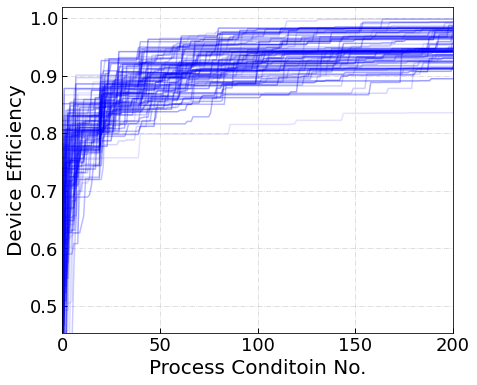

In [16]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
for df_i in BO_list_LHS20:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    ax.plot(range(len(eff_max_acc)),eff_max_acc/np.max(BO_list_LHS20), alpha = 0.3*i/len(BO_list_LHS20)+0.1, c = 'blue')
#plt.scatter(range(len(eff_max_acc)),eff_acc)
i
#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/np.max(BO_list_LHS20),18/np.max(BO_list_LHS20))
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

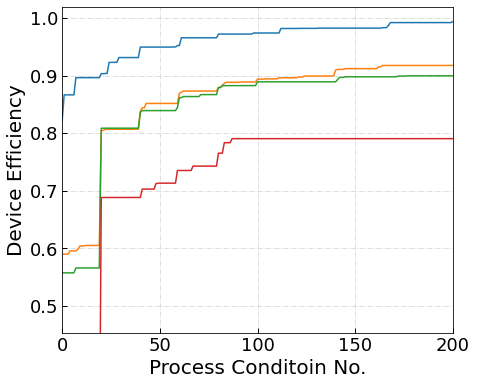

In [17]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
ax.plot(np.maximum.accumulate(np.percentile(BO_list_LHS20, 99, axis = 0))/np.max(BO_list_LHS20))

ax.plot(np.maximum.accumulate(np.median(BO_list_LHS20, axis = 0))/np.max(BO_list_LHS20))

ax.plot(np.maximum.accumulate(np.mean(BO_list_LHS20, axis = 0))/np.max(BO_list_LHS20))

ax.plot(np.maximum.accumulate(np.percentile(BO_list_LHS20, 1, axis = 0))/np.max(BO_list_LHS20))


axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/np.max(BO_list_LHS20),18/np.max(BO_list_LHS20))
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

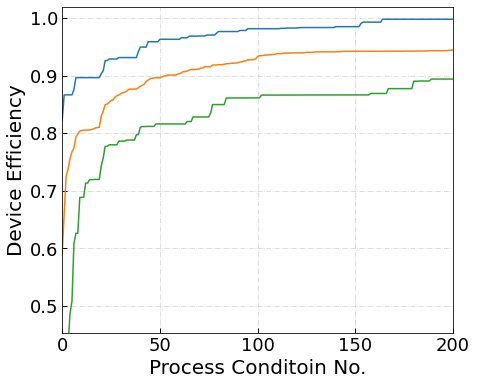

In [18]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
eff_max_runlist = []
for df_i in BO_list_LHS20:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    #ax.plot(range(len(eff_max_acc)),eff_max_acc/np.max(BO_list_wInitCons), alpha = 0.3*i/len(BO_list_LHS20)+0.1, c = 'blue')
    eff_max_runlist.append(eff_max_acc/np.max(BO_list_LHS20))
#plt.scatter(range(len(eff_max_acc)),eff_acc)
ax.plot(np.percentile(eff_max_runlist, 99, axis = 0))
#ax.plot(np.percentile(eff_max_runlist, 99, axis = 0))
ax.plot(np.percentile(eff_max_runlist, 50, axis = 0))
ax.plot(np.percentile(eff_max_runlist, 1, axis = 0))

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/np.max(BO_list_LHS20),18/np.max(BO_list_LHS20))
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

In [22]:
BO_list_df = pd.DataFrame(np.transpose(BO_list_LHS20))
BO_list_df.to_excel("BO_benckmark_LHS20_20210701.xls")
BO_list_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.848130,6.525025,7.799381,4.819411,12.973541,2.654756,13.342042,11.907091,8.744083,9.939074,...,12.007435,14.234549,8.508182,12.841791,10.748608,12.155543,11.104712,11.457757,6.808186,4.113615
1,10.868601,9.998367,8.929009,6.595080,3.678022,5.080511,6.443271,15.308762,4.179381,11.870304,...,6.662359,7.148079,15.505921,12.671246,13.739421,13.233798,8.459586,6.905395,9.001451,10.200558
2,8.156831,2.483157,8.539529,8.082802,8.247689,9.068448,6.831286,11.146754,14.624589,5.340498,...,13.283565,6.313608,13.060626,6.253361,10.222905,10.799656,8.374237,9.840336,8.796335,13.225021
3,8.600509,10.645571,4.553520,6.249792,12.385699,14.362883,8.338098,7.612341,12.043494,14.573578,...,4.841438,14.150776,11.668101,4.300886,10.594810,9.787485,7.493695,9.097635,12.799409,7.989831
4,11.531658,7.537909,3.465397,14.063751,5.589998,9.863787,11.085158,5.443830,9.405408,13.799671,...,11.352238,7.900701,7.670374,13.311156,8.410649,10.967391,12.088198,6.729435,12.516972,5.977811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,17.612124,15.974337,14.718313,16.331418,16.644047,14.403627,14.064095,16.635652,17.197191,16.514464,...,10.938396,14.022257,16.149819,16.018137,16.507817,16.356284,17.383345,17.628210,17.308791,16.587076
316,17.257745,15.157951,13.463506,16.648103,16.694721,14.450417,13.591557,16.335868,17.182147,17.354872,...,16.106041,15.334390,12.894480,16.997917,16.277274,16.358520,17.378803,14.555372,17.315557,16.495757
317,17.630717,15.112453,13.985306,16.219671,15.929941,14.301178,14.170623,16.134708,17.183145,17.361638,...,14.971377,14.440594,15.811585,14.964712,14.325264,16.366782,17.339261,17.318345,17.251423,15.784114
318,17.657805,13.063723,13.916097,16.562304,14.759177,15.365900,13.979067,16.273938,17.255599,15.694275,...,16.105167,16.580807,16.141536,16.650659,16.206674,16.325637,16.635652,17.525329,14.304751,16.500179
